In [1]:
from timeit import default_timer
start = default_timer()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')


In [2]:
st = default_timer()

#Loading data
movies = pd.read_csv('../data/movies.csv')
ratings = pd.read_csv('../data/ratings.csv')
    


### 1. Movies data
- Initial Data Analysis
- Fixing data formats (seperating columns, fixing formats)
- Checking for NULL values
- Removing Null Values
- Exploratory Data Analysis

In [3]:
#Understanding the movies.csv file
print('Size of movies data set= ',movies.shape)

Size of movies data set=  (27278, 3)


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
print('\nData tyeps: \n',movies.dtypes)


Data tyeps: 
 movieId     int64
title      object
genres     object
dtype: object


#### Split title and release year in separate columns in movies dataframe

In [6]:
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)

movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)

#removing the year from string
movies.title = movies.title.str[:-7]
movies.head()



,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0


In [7]:
print ("Number of movies Null values: ", max(movies.isnull().sum()))
movies.dropna(inplace=True)
print('New Size of movies data set= ',movies.shape)

Number of movies Null values:  22
New Size of movies data set=  (27256, 4)


In [8]:
#Seperate genres of Movies in columns
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies_genreSep = movies.join(movies.genres.str.get_dummies().astype(bool))
movies_genreSep = movies_genreSep.drop('genres', axis=1)
#movies_genreSep = movies_genreSep.rename(columns={'(no genres listed)':'NoGenre'})

In [9]:
print('New size of movies data =' , movies_genreSep.shape)
movies_genreSep.head()

New size of movies data = (27256, 23)


,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995.0,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji,1995.0,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II,1995.0,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


Text(0.5, 1.0, 'Count of Movies per Year')

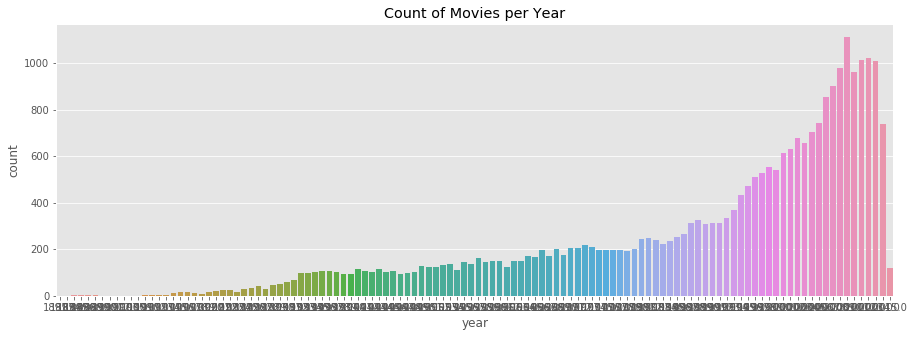

In [10]:
plt.figure(figsize=(15,5))
ax=sns.countplot(x='year', data = movies_genreSep)
plt.title('Count of Movies per Year')

#### Movies, in total and per genre

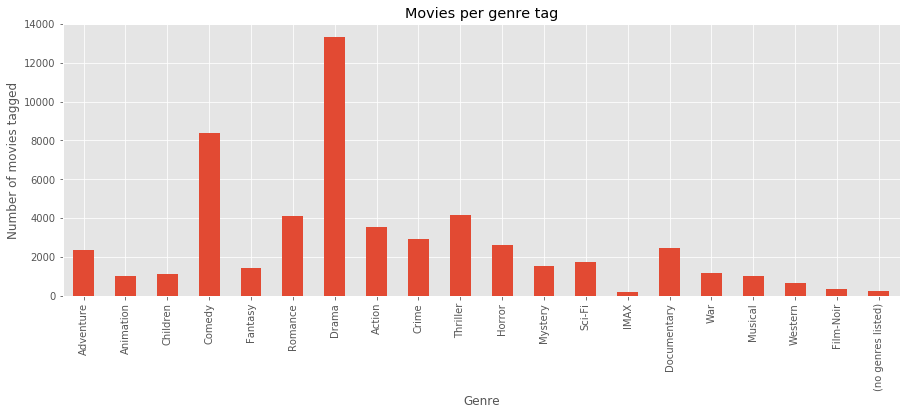

In [11]:
dftmp = movies_genreSep[['movieId', 'year']].groupby('year')
df = pd.DataFrame()

# Plot histogram for each individual genre
for genre in genres_unique.genre:
    dftmp = movies_genreSep[movies_genreSep[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)

# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

### 2. Ratings data
- Initial Data Analysis
- Check for NULL
- Identify Outliers


In [12]:
#Understanding the ratings.csv file
print("Size of ratings data set = ", ratings.shape)

Size of ratings data set =  (20000263, 4)


In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [14]:
print('\nData tyeps: \n',ratings.dtypes)


Data tyeps: 
 userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [15]:
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))

Number of ratings Null values:  0


Text(0, 0.5, 'Count')

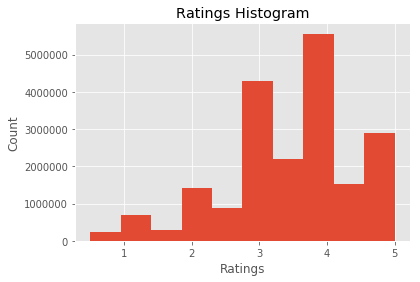

In [27]:
plt.hist(ratings.rating)
plt.title('Ratings Histogram')
plt.xlabel('Ratings')
plt.ylabel('Count')

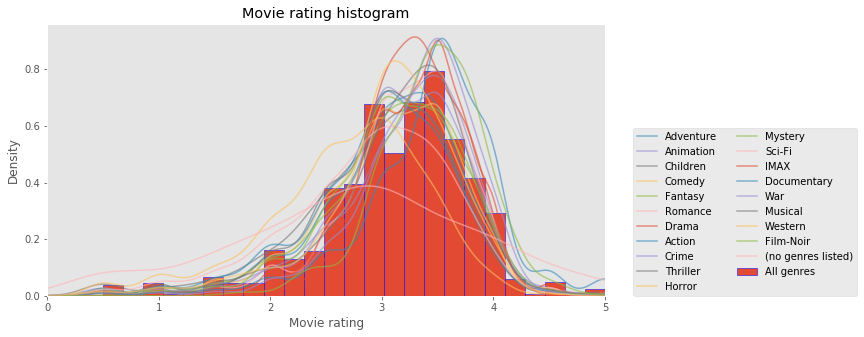

In [17]:
#AVG & SD of Ratings PER genre is calculated below

# Initialize empty list to capture basic stats by genre
rating_stats = []

# Plot general histogram of all ratings
dftmp = ratings[['movieId','rating']].groupby('movieId').mean()
dftmp.hist(bins=25, grid=False, edgecolor='b', density=True, label ='All genres', figsize=(10,5))

# Plot histograms (kde lines for better visibility) per genre
for genre in genres_unique.genre:
    dftmp = movies_genreSep[movies_genreSep[genre]==True]
    dftmp = ratings[ratings.set_index('movieId').index.isin(dftmp.set_index('movieId').index)]
    dftmp = dftmp[['movieId','rating']].groupby('movieId').mean()
    dftmp.rating.plot(grid=False, alpha=0.6, kind='kde', label=genre)
    avg = dftmp.rating.mean()
    std = dftmp.rating.std()
    rating_stats.append((genre, avg, std))
plt.legend(loc=(1.05,0), ncol=2)
plt.xlim(0,5)
plt.xlabel('Movie rating')
plt.title('Movie rating histogram')
plt.show()

### Outliers in Ratings
#### Genre Outliers

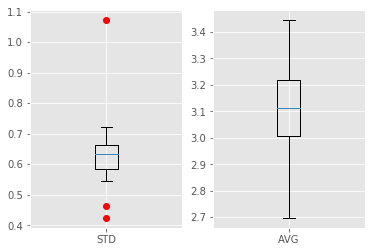

In [20]:
rating_sum = pd.DataFrame(rating_stats,  columns=['genre', 'average', 'std_dev'])
rating_sum.set_index('genre', inplace=True)
f,(ax1,ax2)=plt.subplots(1, 2)
a=ax1.boxplot(rating_sum.std_dev, labels=['STD'], sym="ro")
b=ax2.boxplot(rating_sum.average, labels=['AVG'], sym="ro")



In [21]:


q1, q3= np.percentile(rating_sum.std_dev,[25,75])
iqr=q3-q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 

genre_outliers = list(rating_sum[(rating_sum.std_dev<lower_bound) | (rating_sum.std_dev>upper_bound)].index)
print('Outliers in genre are : ',genre_outliers)

Outliers in genre are :  ['IMAX', 'Film-Noir', '(no genres listed)']


#### Avg rating per user ID

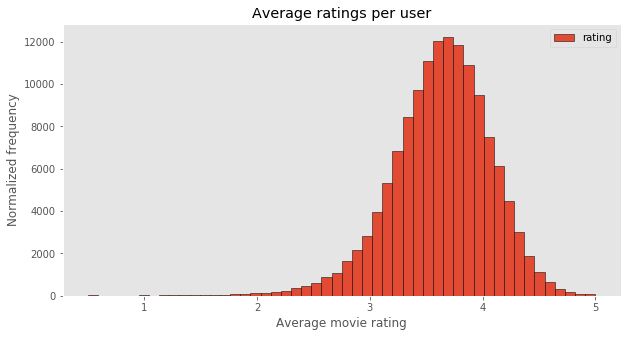

In [22]:
#AVG RATING PER USER ID
dftmp = ratings[['userId','rating']].groupby('userId').mean()
# Plot histogram
a=dftmp.plot(kind='hist', bins=50, grid=0,  edgecolor='black', figsize=(10,5))
plt.xlabel ('Average movie rating')
plt.ylabel ('Normalized frequency')
plt.title ('Average ratings per user')
plt.show()

#### Number of ratings per user

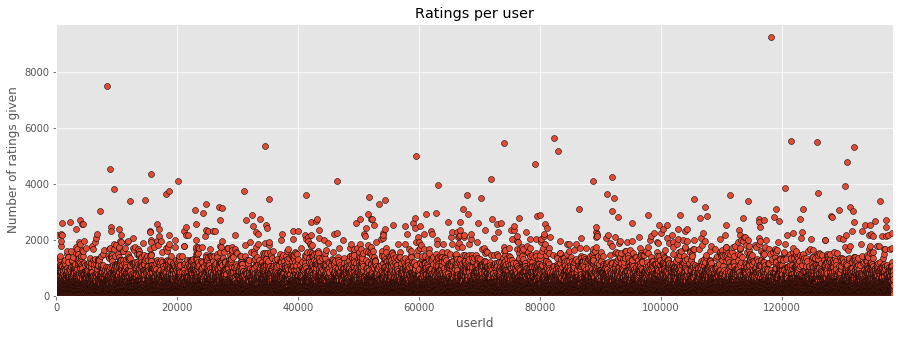

In [23]:
# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('userId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,len(dftmp.index))
plt.ylim(0,)
plt.title('Ratings per user')
plt.xlabel('userId')
plt.ylabel('Number of ratings given')
plt.show()

In [39]:
user_outliers=list(dftmp[dftmp.num_ratings>6000].index)

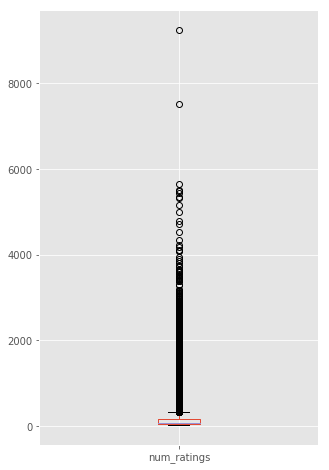

In [36]:
plt.figure(figsize=(5,8))
dftmp.boxplot()


In [41]:
print('User ID outliers are:',user_outliers)

User ID outliers are: [8405, 118205]


### Removing outliers:
- Removing all the movies with genre outliers and their respective rating records
- Removing all ratings of the outlier users